In [1]:
import torch
import tonic
import tonic.transforms
import torchvision

In [2]:
torch.manual_seed(0)

In [3]:
PATH = 'experiment/experiment-09'
import sys
sys.path.append(PATH)

In [4]:
n = 4000
time_jitter_std = 10000

In [5]:
sensor_size = tonic.datasets.NMNIST.sensor_size

original_transform = tonic.transforms.Compose([
            tonic.transforms.Denoise(filter_time=10000),
            tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=30),
            torch.from_numpy,
        ])

# Uniform
uniform_transform = tonic.transforms.Compose([
            tonic.transforms.Denoise(filter_time=10000),
            tonic.transforms.UniformNoise(sensor_size=sensor_size, n=n),
            tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=30),
            torch.from_numpy,
        ])

# Jitter
jitter_transform = tonic.transforms.Compose([
            tonic.transforms.Denoise(filter_time=10000),
            tonic.transforms.TimeJitter(std=time_jitter_std, clip_negative=True),
            tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=30),
            torch.from_numpy,
        ])

# Complex
complex_transform = tonic.transforms.Compose([
            tonic.transforms.Denoise(filter_time=10000),
            tonic.transforms.TimeJitter(std=time_jitter_std, clip_negative=True),
            tonic.transforms.UniformNoise(sensor_size=sensor_size, n=n),
            tonic.transforms.ToFrame(sensor_size=sensor_size, n_time_bins=30),
            torch.from_numpy,
        ])

In [6]:
original_dataset = tonic.datasets.NMNIST(save_to='/DATA/hwkang', train=False, transform=original_transform)
uniform_dataset = tonic.datasets.NMNIST(save_to='/DATA/hwkang', train=False, transform=uniform_transform)
jitter_dataset = tonic.datasets.NMNIST(save_to='/DATA/hwkang', train=False, transform=jitter_transform)
complex_dataset = tonic.datasets.NMNIST(save_to='/DATA/hwkang', train=False, transform=complex_transform)

In [7]:
from torch.utils.data import DataLoader
import multiprocessing

original_loader = DataLoader(original_dataset, batch_size=100, num_workers=multiprocessing.cpu_count() // 2, shuffle=False)
uniform_loader = DataLoader(uniform_dataset, batch_size=100, num_workers=multiprocessing.cpu_count() // 2, shuffle=False)
jitter_loader = DataLoader(jitter_dataset, batch_size=100, num_workers=multiprocessing.cpu_count() // 2, shuffle=False)
complex_loader = DataLoader(complex_dataset, batch_size=100, num_workers=multiprocessing.cpu_count() // 2, shuffle=False)

In [8]:
import itertools
original_batch, label = next(itertools.islice(original_loader, 87, 88)) # >> [b, t, c, x, y], [b]
uniform_batch, _ = next(itertools.islice(uniform_loader, 87, 88))
jitter_batch, _ = next(itertools.islice(jitter_loader, 87, 88))
complex_batch, _ = next(itertools.islice(complex_loader, 87, 88))

In [9]:
original_frames = original_batch[0] # >> [t, c, x, y]
uniform_frames = uniform_batch[0] 
jitter_frames = jitter_batch[0] 
complex_frames = complex_batch[0] 

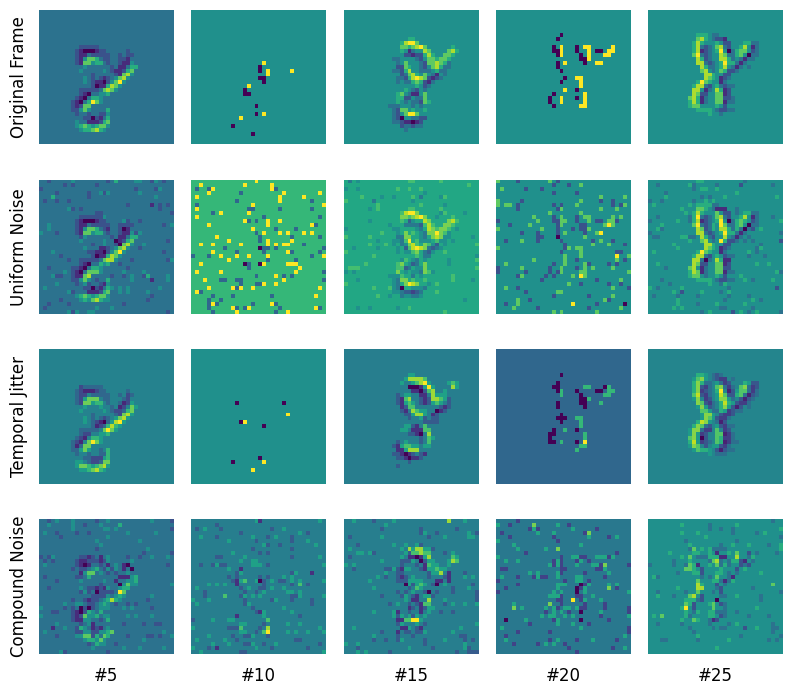

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))

def get_selected_frames(frames):
    _1, _2, _3, _4, _5 = frames[5], frames[10], frames[15], frames[20], frames[25]
    return [_1, _2, _3, _4, _5]

frame_list = []

frame_list.append(get_selected_frames(original_frames))
frame_list.append(get_selected_frames(uniform_frames))
frame_list.append(get_selected_frames(jitter_frames))
frame_list.append(get_selected_frames(complex_frames))

row_labels = ['Original Frame', 'Uniform Noise', 'Temporal Jitter', 'Compound Noise']
xlabels = ['#5', '#10', '#15', '#20', '#25']

for row in range(4):
    for col in range(5):
        ax = plt.subplot(4, 5, row * 5 + col + 1)
        ax.imshow(frame_list[row][col][0] - frame_list[row][col][1])
        ax.axis('off')

        # 각 행의 첫 번째 서브플롯에만 텍스트 추가
        if col == 0:
            ax.text(-0.15, 0.5, row_labels[row], fontsize=12, ha='center', va='center', rotation=90, transform=ax.transAxes)

# 가장 아래쪽 중앙에 텍스트 추가
for col in range(5):
    plt.subplot(4, 5, 15 + col + 1)  # 마지막 행(4행)의 각 열 위치
    plt.text(0.5, -0.1, xlabels[col], ha='center', va='top', fontsize=12, transform=plt.gca().transAxes)
    plt.axis('off')  # 텍스트 출력할 곳의 축을 표시하지 않음

plt.subplots_adjust(left=0.2, bottom=0.2, hspace=+0.1)  # 텍스트를 보기 위해 여백 조정
plt.tight_layout()
plt.savefig('frame_visualization.png')
plt.show()